In [1]:
import os
import yaml
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import torch
from torchvision.utils import save_image
from torchvision import transforms
import torch.nn as nn

from data_loaders_l import SynthesisDataModule
from model_architectures import CVAE, DDPM
torch.set_float32_matmul_precision('medium')
# Load configuration
with open('config_l.yaml', 'r') as f:
    config = yaml.safe_load(f)
# Extract parameters from config
learning_rate = config['learning_rate']
latent_dim = config.get('latent_dim', 100)
label_dim = config.get('label_dim', 4)
model_dir = config.get('model_dir', 'saved_models')

# play around in jupyter
batch_size = 128
num_epochs = 100
experiment_name = "J001_Lightning_synthesis_CVAE"

samples_per_class = 400 # samples to use from each class


# Prepare output directories
experiment_path = os.path.join('experiments', experiment_name)
os.makedirs(experiment_path, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Define the data

In [2]:
# Set up data module
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)),  # Rescale to [0,1]. Necessary to do explicitly with nibabel as ToTensor will omit it.
    # transforms.Lambda(apply_mask),  # Apply the mask to focus on non-zero regions
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.to(torch.float32))
])

data_module = SynthesisDataModule(batch_size=batch_size, transform=transform, samples_per_class=samples_per_class) # sample 100 from each as a sanity check

## Visualize some of the dataset for sanity

In [3]:
data_module_vis = SynthesisDataModule(batch_size=1, transform=transform)
data_module_vis.setup()

# Access the underlying dataset.
dataset = data_module_vis.dataset

for idx in range(min(3, len(dataset))):
    img, label = dataset[idx]
    print(f"Sample {idx} - Label: {label.item()}")
    print(f"  min:  {img.min().item():.6f}")
    print(f"  max:  {img.max().item():.6f}")
    print(f"  mean: {img.mean().item():.6f}\n")

Sample 0 - Label: 0
  min:  -1.000000
  max:  1.000000
  mean: -0.900564

Sample 1 - Label: 0
  min:  -1.000000
  max:  1.000000
  mean: -0.711619

Sample 2 - Label: 0
  min:  -1.000000
  max:  1.000000
  mean: -0.741079



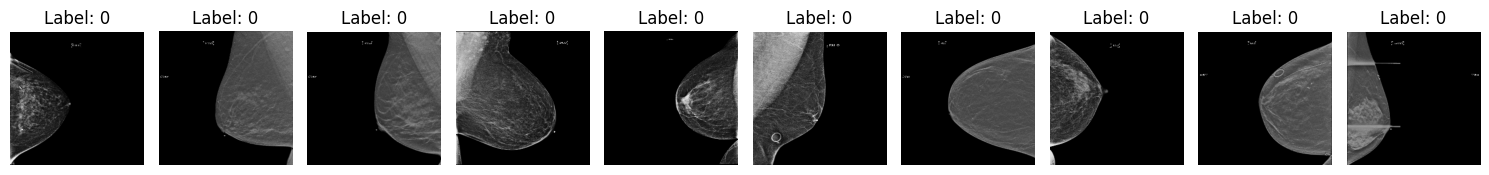

In [4]:
import matplotlib.pyplot as plt

# Number of samples to visualize.
num_samples = min(10, len(dataset))

# Create subplots to show the images.
fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    img, label = dataset[i]
    # Remove the channel dimension if the image is grayscale.
    img_np = img.squeeze().cpu().numpy()
    axs[i].imshow(img_np, cmap='gray')
    axs[i].set_title(f"Label: {label.item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [5]:
# Ensure the dataset is initialized
data_module.setup()

# Now get a batch from the DataLoader
train_loader = data_module.train_dataloader()
imgs, labels = next(iter(train_loader))

print("Batch Image Shape:", imgs.shape)  # Expecting [batch_size, 1, 256, 256]
print("Batch Labels Shape:", labels.shape)  # Expecting [batch_size]

Batch Image Shape: torch.Size([128, 1, 256, 256])
Batch Labels Shape: torch.Size([128])


# MODELS CODE. Update and copy paste to script after.

In [6]:
import torch.nn.functional as F
import numpy as np

with open('config_l.yaml', 'r') as f:
    config = yaml.safe_load(f)

learning_rate = config['learning_rate']
timesteps = config.get('timesteps', 1000)  # Number of diffusion steps
label_dim = config.get('label_dim', 4)
guidance_scale = config.get('guidance_scale', 5.0)  # Strength of classifier-free guidance


In [7]:
# Sinusoidal Position Embeddings for Timestep Embedding
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.exp(-np.log(10000) * torch.arange(half_dim, device=device) / (half_dim - 1))
        embeddings = time[:, None] * embeddings[None, :]
        return torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        
# Initialize module with dim=256
embedding_layer = SinusoidalPositionEmbeddings(dim=256)

# Test with a sample batch of timesteps
timesteps = torch.randint(0, 1000, (8,))  # Simulate batch_size=8 timesteps
output = embedding_layer(timesteps)

print("Input Timesteps Shape:", timesteps.shape)  # Expected: [8]
print("Output Embeddings Shape:", output.shape)  # Expected: [8, 256]


Input Timesteps Shape: torch.Size([8])
Output Embeddings Shape: torch.Size([8, 256])


In [8]:
# Define label embedding layer
label_dim = 4  # Assume 4 classes (benign, malignant, etc.)
embedding_dim = 256
label_embedding = nn.Embedding(label_dim, embedding_dim)

# Sample batch of labels (batch size = 8)
labels = torch.randint(0, label_dim, (8,))  # Random labels in [0,3]
embedded_labels = label_embedding(labels)

print("Input Labels:", labels)
print("Input Labels Shape:", labels.shape)  # Expected: [8]
print("Output Embeddings Shape:", embedded_labels.shape)  # Expected: [8, 256]


Input Labels: tensor([0, 0, 0, 3, 3, 0, 3, 1])
Input Labels Shape: torch.Size([8])
Output Embeddings Shape: torch.Size([8, 256])


In [9]:
# UNet-like Denoiser Model with Classifier-Free Guidance
class DenoiseModel(nn.Module):
    def __init__(self, label_dim, time_dim=256):
        super().__init__()
        self.label_dim = label_dim
        self.label_embedding = nn.Embedding(label_dim, time_dim)
        self.unconditional_embedding = nn.Parameter(torch.randn(1, time_dim))
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        self.conv1 = nn.Conv2d(2, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 1, 3, padding=1)

        self.activation = nn.SiLU()

    def forward(self, x, t, labels=None):
        # Time embeddings
        time_emb = self.time_mlp(t)

        if labels is not None and isinstance(labels, torch.Tensor) and (labels != -1).any():
            valid_labels = labels.clone()
            unconditional_mask = (labels == -1).unsqueeze(1)
            
            # Ensure valid indices for label embedding
            label_emb = self.label_embedding(torch.clamp(valid_labels, min=0))
            
            # Use torch.where to handle conditional/unconditional embeddings
            label_emb = torch.where(unconditional_mask, self.unconditional_embedding, label_emb)
        else:
            # Pure unconditional embedding
            label_emb = self.unconditional_embedding.expand(x.size(0), -1)

        # Combine time and label embeddings
        emb = time_emb[:, :, None, None] + label_emb[:, :, None, None]

        # print("Embedding Shape Before Expansion:", emb.shape)  # Should be [batch_size, 1, 1, 1]
        
        print("Embedding Shape Before Expansion:", emb.shape)  # Should be [batch_size, 256, 1, 1]
        # Ensure emb has the correct shape (batch_size, 1, 256, 256) before concatenation
        # emb = emb.expand(-1, 1, x.shape[2], x.shape[3])  # Change -1 to 1 for channels
        emb = emb.permute(0, 2, 3, 1).expand(-1, x.shape[2], x.shape[3], -1).permute(0, 3, 1, 2)

        # Instead of expanding to 256 channels, reduce it to 1 channel
        emb = emb.mean(dim=1, keepdim=True)  # Reduce 256 channels → 1 channel

        print("Embedding Shape After Expansion:", emb.shape)  # Should be [batch_size, 256, 256, 256]
        
        # Concatenate the embedding with the image
        print("Input Shape before concat:", x.shape)  # Should be [batch_size, 1, 256, 256]
        x = torch.cat((x, emb), dim=1)  # Should now have exactly 2 channels
        print("Final Input Shape to Conv1:", x.shape)  # Should be [batch_size, 2, 256, 256]

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        return self.conv4(x)

In [10]:
# Initialize the model
batch_size = 8
image_size = 256
label_dim = 4
time_dim = 256

model = DenoiseModel(label_dim, time_dim)

# Generate fake input data
img_sample = torch.randn(batch_size, 1, image_size, image_size)  # Fake grayscale images
timestep_sample = torch.randint(0, 1000, (batch_size,))  # Random timesteps
label_sample = torch.randint(0, label_dim, (batch_size,))  # Random labels

# Run a forward pass
with torch.no_grad():
    output = model(img_sample, timestep_sample, label_sample)

print("Input Image Shape:", img_sample.shape)  # Expected: [8, 1, 256, 256]
print("Timestep Shape:", timestep_sample.shape)  # Expected: [8]
print("Label Shape:", label_sample.shape)  # Expected: [8]
print("Output Image Shape:", output.shape)  # Expected: [8, 1, 256, 256]


Embedding Shape Before Expansion: torch.Size([8, 256, 1, 1])
Embedding Shape After Expansion: torch.Size([8, 1, 256, 256])
Input Shape before concat: torch.Size([8, 1, 256, 256])
Final Input Shape to Conv1: torch.Size([8, 2, 256, 256])
Input Image Shape: torch.Size([8, 1, 256, 256])
Timestep Shape: torch.Size([8])
Label Shape: torch.Size([8])
Output Image Shape: torch.Size([8, 1, 256, 256])


In [11]:
# Diffusion Model with Classifier-Free Guidance
class DDPM(pl.LightningModule):
    def __init__(self, label_dim, learning_rate=learning_rate, timesteps=1000, guidance_scale=guidance_scale, verbose=False):
        super().__init__()
        self.model = DenoiseModel(label_dim)
        self.learning_rate = learning_rate
        self.timesteps = timesteps
        self.verbose = verbose
        self.guidance_scale = guidance_scale

        # Diffusion parameters
        self.register_buffer('betas', torch.linspace(1e-4, 0.02, timesteps))
        self.register_buffer('alphas', 1.0 - self.betas)
        self.register_buffer('alpha_hat', torch.cumprod(self.alphas, dim=0))

    def forward(self, x, t, labels=None):
        # if labels is not None and (labels != -1).any():
        if labels is not None and isinstance(labels, torch.Tensor) and (labels != -1).any():
            # Generate both conditional and unconditional predictions
            noise_pred_cond = self.model(x, t, labels)  # Conditional
            noise_pred_uncond = self.model(x, t, -1)    # Unconditional

            # Combine them using classifier-free guidance
            noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_cond - noise_pred_uncond)
        else:
            # Only unconditional generation
            noise_pred = self.model(x, t, -1)
            
        return noise_pred

    def training_step(self, batch, batch_idx):
        imgs, labels = batch

        batch_size = imgs.shape[0]
        t = torch.randint(0, self.timesteps, (batch_size,), device=imgs.device).long()

        noise = torch.randn_like(imgs, device=imgs.device)
        noisy_imgs = self.q_sample(imgs, t, noise)

        # Randomly drop labels during training (e.g., 10% of the time) for unconditional training
        drop_labels = torch.rand(batch_size, device=imgs.device) < 0.1
        conditional_labels = labels.clone().detach()
        conditional_labels[drop_labels] = -1

        predicted_noise = self.forward(noisy_imgs, t, conditional_labels)
        loss = F.mse_loss(predicted_noise, noise)

        if self.verbose:
            unconditional_ratio = (conditional_labels == -1).float().mean().item()
            print(f"Batch {batch_idx}: Loss = {loss.item():.6f}, Unconditional Ratio = {unconditional_ratio:.2f}")


        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # **Log Noisy and Denoised Images to TensorBoard**
        if batch_idx % 500 == 0:  # Log every 500 batches
            grid_size = min(8, batch_size)  # Show up to 8 images
            imgs_to_show = imgs[:grid_size]
            noisy_to_show = noisy_imgs[:grid_size]
            denoised_to_show = predicted_noise[:grid_size]
    
            # Rescale from [-1,1] to [0,1] for visualization
            imgs_to_show = (imgs_to_show + 1) / 2
            noisy_to_show = (noisy_to_show + 1) / 2
            denoised_to_show = (denoised_to_show + 1) / 2
    
            # Create image grids
            self.logger.experiment.add_images("Original Images", imgs_to_show, global_step=self.current_epoch)
            self.logger.experiment.add_images("Noisy Images", noisy_to_show, global_step=self.current_epoch)
            self.logger.experiment.add_images("Denoised Images", denoised_to_show, global_step=self.current_epoch)

        return loss

    def q_sample(self, x_start, t, noise):
        """ Diffuse the data (add noise) using the forward process q(x_t | x_0) """
        sqrt_alpha_hat = self.alpha_hat[t].to(t.device)[:, None, None, None]
        sqrt_one_minus_alpha_hat = (1.0 - self.alpha_hat[t].to(t.device))[:, None, None, None]
        return sqrt_alpha_hat * x_start + sqrt_one_minus_alpha_hat * noise


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
model = DDPM(label_dim=4, learning_rate=1e-4, timesteps=1000, guidance_scale=5.0, verbose=True)

# Check model device and parameters
print("Model Parameters:", sum(p.numel() for p in model.parameters()))
print("Model Device:", next(model.parameters()).device)

Model Parameters: 216513
Model Device: cpu


Testing the DDPM

In [12]:
# Generate dummy data
batch_size = 8
img_sample = torch.randn(batch_size, 1, 256, 256)  # Sample images
timestep_sample = torch.randint(0, 1000, (batch_size,))  # Random timesteps
noise_sample = torch.randn_like(img_sample)  # Noise

# Move to device
device = next(model.parameters()).device
img_sample, timestep_sample, noise_sample = img_sample.to(device), timestep_sample.to(device), noise_sample.to(device)

# Apply forward process
noisy_img = model.q_sample(img_sample, timestep_sample, noise_sample)

# Check output shape
print("Original Image Shape:", img_sample.shape)
print("Noisy Image Shape:", noisy_img.shape)


Original Image Shape: torch.Size([8, 1, 256, 256])
Noisy Image Shape: torch.Size([8, 1, 256, 256])


In [13]:
# Generate dummy labels
label_sample = torch.randint(0, 4, (batch_size,)).to(device)  # Random class labels

# Forward pass
with torch.no_grad():
    noise_pred = model(noisy_img, timestep_sample, label_sample)

# Check output shape
print("Predicted Noise Shape:", noise_pred.shape)  # Should be [8, 1, 256, 256]

Embedding Shape Before Expansion: torch.Size([8, 256, 1, 1])
Embedding Shape After Expansion: torch.Size([8, 1, 256, 256])
Input Shape before concat: torch.Size([8, 1, 256, 256])
Final Input Shape to Conv1: torch.Size([8, 2, 256, 256])
Embedding Shape Before Expansion: torch.Size([8, 256, 1, 1])
Embedding Shape After Expansion: torch.Size([8, 1, 256, 256])
Input Shape before concat: torch.Size([8, 1, 256, 256])
Final Input Shape to Conv1: torch.Size([8, 2, 256, 256])
Predicted Noise Shape: torch.Size([8, 1, 256, 256])


In [14]:
# Initialize the DDPM model
model = DDPM(label_dim=label_dim, learning_rate=learning_rate)

# Pick one sample
img_sample = imgs[:1]  # Take 1 image from batch
label_sample = labels[:1]  # Take 1 label from batch
timestep_sample = torch.randint(0, model.timesteps, (1,), device=imgs.device).long()

print("Input Shape to Model:", img_sample.shape)  # Should be [1, 1, 256, 256]
# Run a forward pass
with torch.no_grad():
    output = model(img_sample, timestep_sample, label_sample)

print("Output Shape from Model:", output.shape)  # Should match input


Input Shape to Model: torch.Size([1, 1, 256, 256])
Embedding Shape Before Expansion: torch.Size([1, 256, 1, 1])
Embedding Shape After Expansion: torch.Size([1, 1, 256, 256])
Input Shape before concat: torch.Size([1, 1, 256, 256])
Final Input Shape to Conv1: torch.Size([1, 2, 256, 256])
Embedding Shape Before Expansion: torch.Size([1, 256, 1, 1])
Embedding Shape After Expansion: torch.Size([1, 1, 256, 256])
Input Shape before concat: torch.Size([1, 1, 256, 256])
Final Input Shape to Conv1: torch.Size([1, 2, 256, 256])
Output Shape from Model: torch.Size([1, 1, 256, 256])


In [15]:

# Initialize model
model = DDPM(label_dim=label_dim, learning_rate=learning_rate)

# Set up logger
tb_logger = pl_loggers.TensorBoardLogger('logs/', name=experiment_name)

# Set up callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=model_dir,
    filename='jptr-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,
    monitor='train_loss',
    mode='min'
)
early_stopping_callback = EarlyStopping(monitor='train_loss', patience=10, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [ ]:
# Set up Trainer
trainer = pl.Trainer(
    max_epochs=num_epochs,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    logger=tb_logger,
    callbacks=[checkpoint_callback, early_stopping_callback, lr_monitor],
    enable_progress_bar=True,
    gradient_clip_val=0.5
)

# Start training
trainer.fit(model, data_module)

In [1]:
%reload_ext tensorboard
%tensorboard --logdir logs --port 6008